<a href="https://colab.research.google.com/github/SoniaBorsi/Adversarial-Attack-GNN/blob/metattack/metattack_perturbations5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Libraries

In [1]:
# !pip uninstall -y torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv deeprobust
'''
If import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.
'''
#!pip uninstall -y numpy
#!pip install numpy==1.23.5

'\nIf import block fails with a numpy size diff, uncomment and run the two lines below. rerun all blocks after.\n'

In [2]:
!pip install numpy==1.23.5 torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install deeprobust
!pip install networkx matplotlib
!pip install ogb

  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.5 requires 

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
^C
^C
^C
^C


In [1]:
# Import the required modules
import torch
import torch_geometric
import deeprobust

print("PyTorch Version:", torch.__version__)
print("PyG Installed:", torch_geometric.__version__)

import torch.nn.functional as F
import numpy as np

print("Numpy Installed:", np.__version__)

import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as sparse

PyTorch Version: 2.0.0+cu117
PyG Installed: 2.6.1
Numpy Installed: 1.23.5


In [2]:
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_scipy_sparse_matrix, subgraph
from torch_geometric.data import Data
from torch_sparse import from_scipy

from deeprobust.graph.global_attack import Metattack
print("Metattack Imported Successfully")

# Planetoid: Cora, Citeseer, PubMed
# WebKB: Texas
# PolBlogs: polblogs
# Flickr: Flickr
from torch_geometric.datasets import Planetoid, WebKB, PolBlogs, Flickr
# OGB: ogbn-proteins
from ogb.nodeproppred import PygNodePropPredDataset

Metattack Imported Successfully


# Load Datasets
Cora, Citeseer, PubMed, Texas, PolBlogs, and Flickr

In [3]:
'''
from torch_geometric.utils import subgraph
from torch_geometric.data import Data
import os

def subset_graph(data, num_nodes_subset, save_path):
  #Make a subset of a graph if it is too big
  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]
  perm = perm.sort()[0]

  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)

  x = data.x[perm] if data.x is not None else None
  y = data.y[perm] if data.y is not None else None

  new_data = Data(x=x, edge_index=edge_index, y=y)
  torch.save(new_data, save_path)
  print(f"Saved subset graph to {save_path}")
  return new_data
'''

'\nfrom torch_geometric.utils import subgraph\nfrom torch_geometric.data import Data\nimport os \n\ndef subset_graph(data, num_nodes_subset, save_path):\n  #Make a subset of a graph if it is too big\n  perm = torch.randperm(data.num_nodes)[:num_nodes_subset]\n  perm = perm.sort()[0]\n\n  edge_index, _ = subgraph(perm, data.edge_index, relabel_nodes=True)\n\n  x = data.x[perm] if data.x is not None else None\n  y = data.y[perm] if data.y is not None else None\n\n  new_data = Data(x=x, edge_index=edge_index, y=y)\n  torch.save(new_data, save_path)\n  print(f"Saved subset graph to {save_path}")\n  return new_data\n'

In [4]:
# Still failing because using all RAM
'''
import random

def subsample(data, num_nodes):
  node_indices = torch.randperm(data.num_nodes)[:num_nodes]
  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)
  data.x = data.x[node_indices]
  data.y = data.y[node_indices]

  # (Re)define masks
  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.train_mask[:int(0.6 * num_nodes)] = True

  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True

  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask[int(0.8 * num_nodes):] = True

  data.edge_index = edge_index
  return data
'''

'\nimport random\n\ndef subsample(data, num_nodes):\n  node_indices = torch.randperm(data.num_nodes)[:num_nodes]\n  edge_index, _ = subgraph(node_indices, data.edge_index, relabel_nodes=True)\n  data.x = data.x[node_indices]\n  data.y = data.y[node_indices]\n  \n  # (Re)define masks\n  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.train_mask[:int(0.6 * num_nodes)] = True\n\n  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True\n\n  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  data.test_mask[int(0.8 * num_nodes):] = True\n\n  data.edge_index = edge_index\n  return data\n'

In [5]:
# Still failing because uses all RAM

'''
def subsample_ogbn_proteins(dataset, num_nodes=7000):
  full_data = dataset[0]
  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]

  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)
  edge_attr = full_data.edge_attr[edge_mask]

  # Simulate node features if missing
  x = torch.zeros((num_nodes, 1))

  # Subsample y
  y = full_data.y[sampled_nodes]

  # Generate new train/val/test masks
  train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  train_mask[:int(0.6 * num_nodes)] = True
  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True
  test_mask[int(0.8 * num_nodes):] = True

  return Data(
      x=x,
      edge_index=edge_index,
      edge_attr=edge_attr,
      y=y,
      train_mask=train_mask,
      val_mask=val_mask,
      test_mask=test_mask,
  )
'''

'\ndef subsample_ogbn_proteins(dataset, num_nodes=7000):\n  full_data = dataset[0]\n  sampled_nodes = torch.randperm(full_data.num_nodes)[:num_nodes]\n\n  edge_index, edge_mask = subgraph(sampled_nodes, full_data.edge_index, relabel_nodes=True)\n  edge_attr = full_data.edge_attr[edge_mask]\n\n  # Simulate node features if missing\n  x = torch.zeros((num_nodes, 1))\n\n  # Subsample y\n  y = full_data.y[sampled_nodes]\n\n  # Generate new train/val/test masks\n  train_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  val_mask = torch.zeros(num_nodes, dtype=torch.bool)\n  test_mask = torch.zeros(num_nodes, dtype=torch.bool)\n\n  train_mask[:int(0.6 * num_nodes)] = True\n  val_mask[int(0.6 * num_nodes):int(0.8 * num_nodes)] = True\n  test_mask[int(0.8 * num_nodes):] = True\n\n  return Data(\n      x=x,\n      edge_index=edge_index,\n      edge_attr=edge_attr,\n      y=y,\n      train_mask=train_mask,\n      val_mask=val_mask,\n      test_mask=test_mask,\n  )\n'

In [6]:

def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    return Planetoid(root=f"./data/{name}", name=name)[0]
  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
    return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    return PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")[0]
  elif name == "Flickr":
    return Flickr(root=f"./data/Flickr")[0]
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}

# Load datasets for all datasets when using ogbn-proteins, flickr, and pubmed
'''
def load_dataset(name):
  if name in ["Cora", "Citeseer", "PubMed"]:
    data = Planetoid(root=f"./data/{name}", name=name)[0]

    if name == "PubMed":
      data = subsample(data, 5000)
    return data

  elif name == "Texas":
    return WebKB(root=f"./data/{name}", name=name)[0]
  elif name == "PolBlogs":
   return PolBlogs(root=f"./tmp/polblogs")[0]
  elif name == "ogbn-proteins":
    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")
    return subsample_ogbn_proteins(dataset, num_nodes=7000)

  elif name == "Flickr":
    data = Flickr(root=f"./data/Flickr")[0]
    return subsample(data, 5000)
  else:
    raise ValueError("Dataset not found")

datasets = {
    "Cora": load_dataset("Cora"),
    "Citeseer": load_dataset("Citeseer"),
    "PubMed": load_dataset("PubMed"),
    "PolBlogs": load_dataset("PolBlogs"),
    "Texas": load_dataset("Texas"),
    "ogbn-proteins": load_dataset("ogbn-proteins"),
    "Flickr": load_dataset("Flickr")
}
'''

'\ndef load_dataset(name):\n  if name in ["Cora", "Citeseer", "PubMed"]:\n    data = Planetoid(root=f"./data/{name}", name=name)[0]\n\n    if name == "PubMed":\n      data = subsample(data, 5000)\n    return data\n\n  elif name == "Texas":\n    return WebKB(root=f"./data/{name}", name=name)[0]\n  elif name == "PolBlogs":\n   return PolBlogs(root=f"./tmp/polblogs")[0]\n  elif name == "ogbn-proteins":\n    dataset = PygNodePropPredDataset(root="./data/ogb", name="ogbn-proteins")\n    return subsample_ogbn_proteins(dataset, num_nodes=7000)\n\n  elif name == "Flickr":\n    data = Flickr(root=f"./data/Flickr")[0]\n    return subsample(data, 5000)\n  else:\n    raise ValueError("Dataset not found")\n\ndatasets = {\n    "Cora": load_dataset("Cora"),\n    "Citeseer": load_dataset("Citeseer"),\n    "PubMed": load_dataset("PubMed"),\n    "PolBlogs": load_dataset("PolBlogs"),\n    "Texas": load_dataset("Texas"),\n    "ogbn-proteins": load_dataset("ogbn-proteins"),\n    "Flickr": load_dataset("Fli

# Define GCN Model

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super().__init__()
        self.gc1 = GCNConv(num_features, hidden_channels)
        self.gc2 = GCNConv(hidden_channels, num_classes)

        self.nfeat = num_features
        self.nclass = num_classes
        self.hidden_sizes = [hidden_channels]
        self.with_relu = True

    @property
    def gc1_weight(self):
        return self.gc1.lin.weight

    @property
    def gc2_weight(self):
        return self.gc2.lin.weight

    @property
    def weight(self):
        return self.gc1.lin.weight

    def forward(self, x, edge_index):
        x = self.gc1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, edge_index)
        self.output = x
        return x

# Train GCN Model

In [8]:
def train_model(model, data, epochs=100, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

    return model


# Metattack Over All Datasets

In [9]:
def apply_metattack(model, data, num_perturbations):
  # Convert adjacency matrix and features to sparse format
  adj = to_scipy_sparse_matrix(data.edge_index, num_nodes=data.num_nodes).tocsr()
  features = sparse.csr_matrix(data.x.numpy())
  labels = data.y.numpy()

  # Get train and unlabeled indices
  idx_train = data.train_mask.nonzero(as_tuple=True)[0].cpu().numpy()
  idx_unlabeled = (~data.train_mask).nonzero(as_tuple=True)[0].cpu().numpy()

  # Initialize Metattack
  attacker = Metattack(
      model=model,
      nnodes=data.num_nodes,
      attack_structure=True,
      attack_features=False,
      device='cpu'
  )

  # Perform attack
  attacker.attack(
      features,
      adj,
      labels,
      idx_train,
      idx_unlabeled,
      n_perturbations=num_perturbations,
      ll_constraint=False  # This avoids the sparse tensor issue
  )

  # Ensure `modified_adj` and `modified_features` exist and return them
  modified_adj = attacker.modified_adj
  modified_features = attacker.modified_features

  # If Metattack doesn't return features, use the original
  if modified_features is None:
      modified_features = data.x

  return attacker.modified_adj, attacker.modified_features

# Evaluate Model

In [10]:
def evaluate_model(model, data, perturbed_adj, perturbed_features):
  # Check the type of perturbed_adj
  print(f"perturbed_adj type: {type(perturbed_adj)}")

  # Ensure the adjacency matrix is in sparse COO format
  if not perturbed_adj.is_sparse:
        perturbed_adj = perturbed_adj.to_sparse()

  # Get edge_index directly from the sparse tensor (COO format)
  edge_index = perturbed_adj._indices()

  # Use original features if perturbed ones are not returned
  if perturbed_features is None:
        perturbed_x = data.x
  else:
      if hasattr(perturbed_features, "toarray"):
          perturbed_x = torch.tensor(perturbed_features.toarray(), dtype=torch.float)
      else:
          perturbed_x = perturbed_features

  # Forward pass through the model using the perturbed graph and features
  model.eval()
  with torch.no_grad():
        out = model(perturbed_x, edge_index)

  # Ensure test_mask is correctly sized and boolean
  if data.test_mask.shape[0] != data.num_nodes:
    print(f"Adjusting test_mask size for {data.dataset_name}...")
    # Truncate or adjust the size
    data.test_mask = data.test_mask[:data.num_nodes]

  # Flatten test_mask if it's not 1D
  if len(data.test_mask.shape) > 1:
      data.test_mask = data.test_mask.flatten()

  # Ensure data.test_mask has the correct size and is boolean
  data.test_mask = data.test_mask[:data.num_nodes].to(torch.bool)

  #if len(data.test_mask.shape) == 1:
    # Ensure it is boolean
    #data.test_mask = data.test_mask.to(torch.bool)

  # Check the shapes of predictions and ground truth labels
  print(f"Prediction shape: {out.shape}")
  print(f"test_mask shape: {data.test_mask.shape}")
  print(f"Ground truth labels shape: {data.y.shape}")

  # Ensure data.y has the same size as test_mask
  assert data.y.shape[0] == data.num_nodes, "data.y shape mismatch with num_nodes"

  # Get predicted class labels
  pred = out.argmax(dim=1)
  # Compare predictions to ground truth
  correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
  # Calculate accuracy
  acc = correct / data.test_mask.sum().item()

  return acc

# Visualization

In [11]:
def visualize_graph(edge_index, title="Graph"):
  if isinstance(edge_index, torch.Tensor):
    edge_index = edge_index.cpu().numpy()

  if edge_index.shape[0] != 2:
    raise ValueError("Expected edge_index shape [2, num_edges]")

  # Convert to list of edge tuples
  edge_list = list(zip(edge_index[0], edge_index[1]))

  G = nx.Graph()
  G.add_edges_from(edge_list)
  plt.figure(figsize=(8, 6))
  nx.draw(G, node_size=30, edge_color="gray", alpha=0.6, with_labels=False)
  plt.title(title)
  plt.show()

# Create Masks

In [12]:
def split_masks(data, train_ratio=0.6, val_ratio=0.2):
  num_nodes = data.num_nodes
  indices = torch.randperm(num_nodes)

  train_size = int(train_ratio * num_nodes)
  val_size = int(val_ratio * num_nodes)

  data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
  data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

  data.train_mask[indices[:train_size]] = True
  data.val_mask[indices[train_size:train_size + val_size]] = True
  data.test_mask[indices[train_size + val_size:]] = True

  return data

# Run Experiments

In [13]:
# TODO: make num_perturbations 0.2 * number of edges (once initial experiments run)

def run_experiment(dataset_name):
  dataset = load_dataset(dataset_name)

  if isinstance(dataset, Data):
    # Already a Data object
    data = dataset
  else:
    # Dataset is a list-like object (like Planetoid)
    data = dataset[0]

  if data.x is None:
    # Patching missing features (for PolBlogs, speficially)
    # All zero-features carry no useful info -> poor performance,
    # so each node has a unique identifier (one-hot encoding). GNN can differentiate them based on graph structure + node identity
    print(f"{dataset_name} patching missing features...")
    data.x = torch.eye(data.num_nodes)

  # Check the shape of the masks and labels BEFORE: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  if not hasattr(data, 'train_mask') or data.train_mask.shape[0] != data.num_nodes:
    # dataset that doesnt come with masks ie. built-in train/test/val splits
    print(f"{dataset_name} making masks...")
    data = split_masks(data)
  else:
    if len(data.train_mask.shape) > 1:
      # If the train_mask exists but is not 1D, fix it to be
      print(f"Fixing train_mask_shape for {dataset_name}...")
      data.train_mask = data.train_mask.view(-1)

  # check train_mask is correct (Texas)
  if data.train_mask.shape[0] != data.num_nodes:
    print(f"Adjusting train_masks size for {dataset_name}...")
    # Truncate or adjust the size
    data.train_mask = data.train_mask[:data.num_nodes]
  if len(data.train_mask.shape) == 1:
    # Ensure it is boolean
    data.train_mask = data.train_mask.to(torch.bool)

  # Check the shape of the masks and labels AFTER: debug
  #print(f"train_mask shape: {data.train_mask.shape}")
  #print(f"data.y shape: {data.y.shape}")

  num_classes = len(torch.unique(data.y))

  print("=" * 100)
  print(f"Dataset: {dataset_name}\n")
  print(f"Number of nodes: {data.num_nodes}")
  print(f"Number of features: {data.num_features}")
  print(f"Number of classes: {num_classes}\n")

  model = GCN(data.num_features, 16, num_classes)
  model = train_model(model, data)

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Original Graph")
    visualize_graph(data.edge_index, title=f"{dataset_name}: Before Metattack")

  # TODO: make num_perturbations 0.2 * number of edges once initial experiments run
  perturbed_adj, perturbed_features = apply_metattack(model, data, num_perturbations=5)
  edge_index_perturbed = perturbed_adj.nonzero().t()

  if data.num_nodes <= 5000:
    print("-" * 100)
    print("Perturbed Graph")
    visualize_graph(edge_index_perturbed, title=f"{dataset_name}: After Metattack")

  acc = evaluate_model(model, data, perturbed_adj, perturbed_features)
  print(f"Accuracy after Metattack on {dataset_name}: {acc:.4f}")


# Execution

Dataset: Cora

Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Epoch 0, Loss: 1.9512
Epoch 10, Loss: 0.7704
Epoch 20, Loss: 0.2023
Epoch 30, Loss: 0.0971
Epoch 40, Loss: 0.0904
Epoch 50, Loss: 0.0379
Epoch 60, Loss: 0.0425
Epoch 70, Loss: 0.0398
Epoch 80, Loss: 0.0483
Epoch 90, Loss: 0.0393
----------------------------------------------------------------------------------------------------
Original Graph


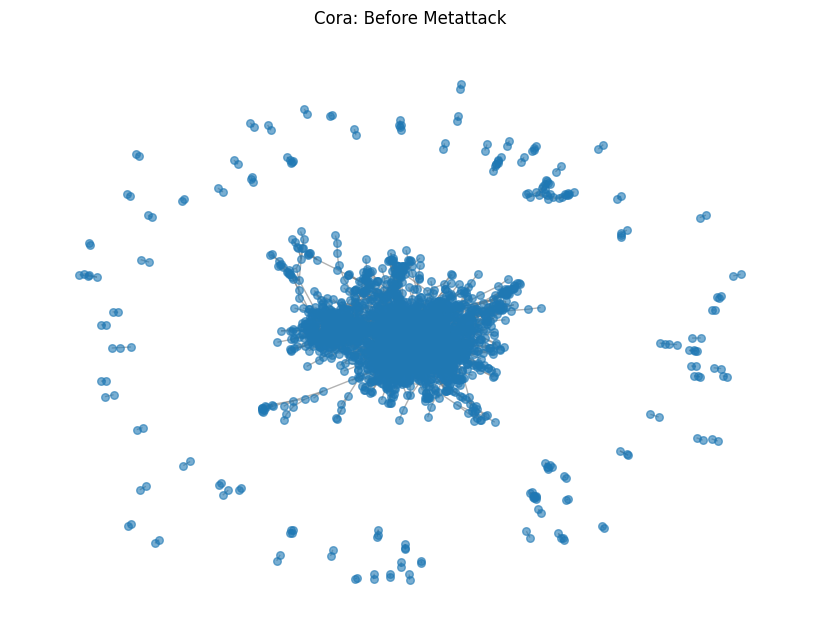

Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.6748512387275696
GCN acc on unlabled data: 0.786993769470405
attack loss: 0.3425893485546112


Perturbing graph:  20%|██        | 1/5 [00:19<01:18, 19.57s/it]

GCN loss on unlabled data: 0.6911346316337585
GCN acc on unlabled data: 0.7916666666666666
attack loss: 0.34767788648605347


Perturbing graph:  40%|████      | 2/5 [00:39<00:58, 19.57s/it]

GCN loss on unlabled data: 0.7218486666679382
GCN acc on unlabled data: 0.7714174454828661
attack loss: 0.3502824306488037


Perturbing graph:  60%|██████    | 3/5 [01:00<00:40, 20.31s/it]

GCN loss on unlabled data: 0.6786909699440002
GCN acc on unlabled data: 0.7830996884735203
attack loss: 0.3391401767730713


Perturbing graph:  80%|████████  | 4/5 [01:19<00:19, 19.70s/it]

GCN loss on unlabled data: 0.6585494875907898
GCN acc on unlabled data: 0.7908878504672897
attack loss: 0.3554096817970276


Perturbing graph: 100%|██████████| 5/5 [01:37<00:00, 19.45s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


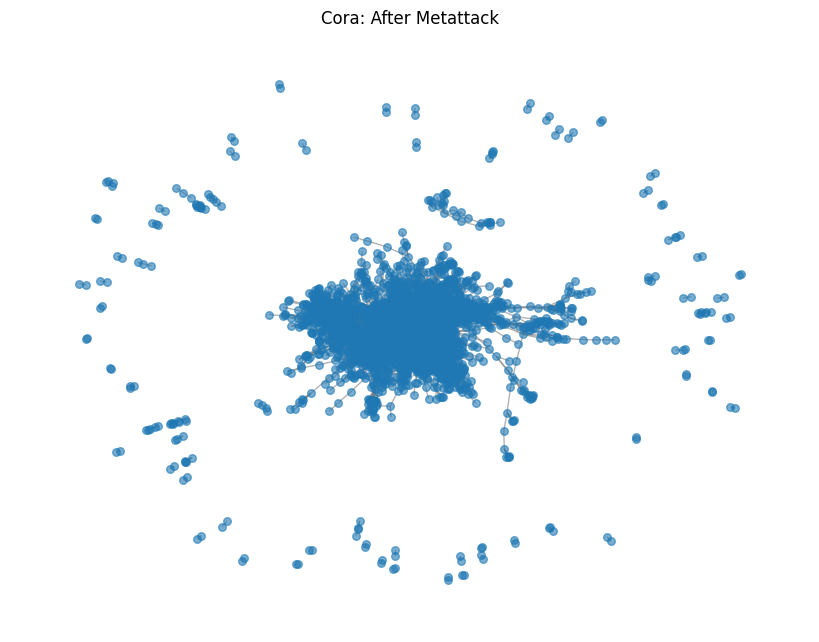

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([2708, 7])
test_mask shape: torch.Size([2708])
Ground truth labels shape: torch.Size([2708])
Accuracy after Metattack on Cora: 0.7990
Dataset: Citeseer

Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Epoch 0, Loss: 1.7980
Epoch 10, Loss: 0.3383
Epoch 20, Loss: 0.1221
Epoch 30, Loss: 0.0462
Epoch 40, Loss: 0.0614
Epoch 50, Loss: 0.0280
Epoch 60, Loss: 0.0391
Epoch 70, Loss: 0.0342
Epoch 80, Loss: 0.0425
Epoch 90, Loss: 0.0528
----------------------------------------------------------------------------------------------------
Original Graph


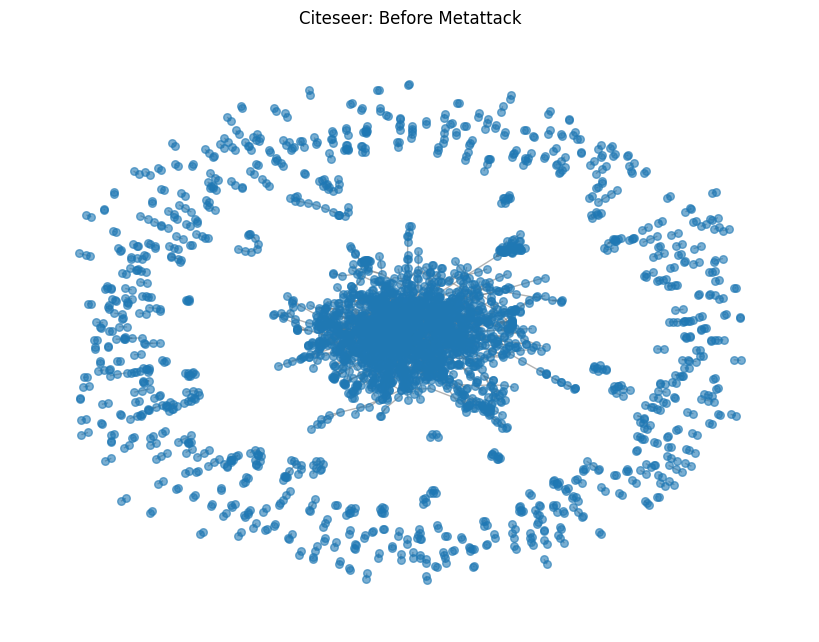

Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 1.4158440828323364
GCN acc on unlabled data: 0.6192703461178671
attack loss: 0.5015872120857239


Perturbing graph:  20%|██        | 1/5 [00:43<02:55, 43.76s/it]

GCN loss on unlabled data: 1.3415727615356445
GCN acc on unlabled data: 0.6367321484253197
attack loss: 0.513210654258728


Perturbing graph:  40%|████      | 2/5 [01:22<02:03, 41.02s/it]

GCN loss on unlabled data: 1.2345013618469238
GCN acc on unlabled data: 0.6342376052385407
attack loss: 0.4971454441547394


Perturbing graph:  60%|██████    | 3/5 [02:04<01:22, 41.37s/it]

GCN loss on unlabled data: 1.3567640781402588
GCN acc on unlabled data: 0.6158403492360461
attack loss: 0.5255263447761536


Perturbing graph:  80%|████████  | 4/5 [02:47<00:42, 42.11s/it]

GCN loss on unlabled data: 1.3439997434616089
GCN acc on unlabled data: 0.6255067040848145
attack loss: 0.524692177772522


Perturbing graph: 100%|██████████| 5/5 [03:30<00:00, 42.16s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


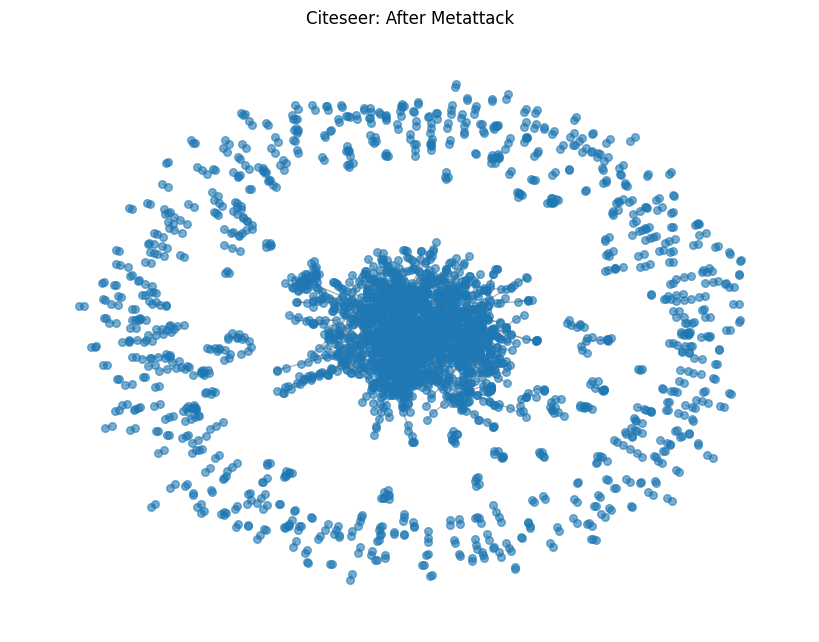

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([3327, 6])
test_mask shape: torch.Size([3327])
Ground truth labels shape: torch.Size([3327])
Accuracy after Metattack on Citeseer: 0.6920
PolBlogs patching missing features...
PolBlogs making masks...
Dataset: PolBlogs

Number of nodes: 1490
Number of features: 1490
Number of classes: 2

Epoch 0, Loss: 0.6911
Epoch 10, Loss: 0.4429
Epoch 20, Loss: 0.2401
Epoch 30, Loss: 0.1496
Epoch 40, Loss: 0.1161
Epoch 50, Loss: 0.1120
Epoch 60, Loss: 0.0998
Epoch 70, Loss: 0.0990
Epoch 80, Loss: 0.0918
Epoch 90, Loss: 0.0865
----------------------------------------------------------------------------------------------------
Original Graph


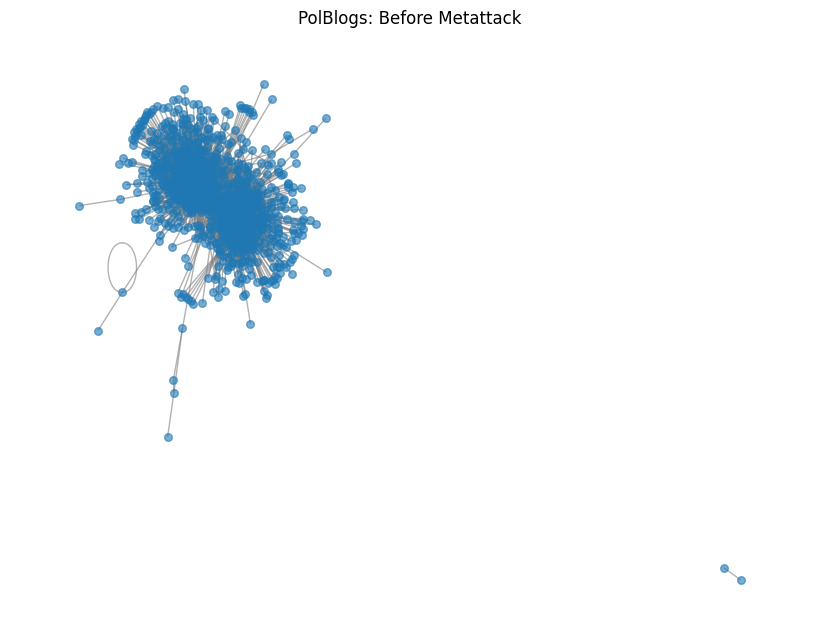

Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 0.4470871686935425
GCN acc on unlabled data: 0.8137583892617449
attack loss: 0.43499574065208435


Perturbing graph:  20%|██        | 1/5 [00:04<00:19,  4.82s/it]

GCN loss on unlabled data: 0.4605359435081482
GCN acc on unlabled data: 0.8036912751677853
attack loss: 0.4449363946914673


Perturbing graph:  40%|████      | 2/5 [00:09<00:14,  4.83s/it]

GCN loss on unlabled data: 0.45983564853668213
GCN acc on unlabled data: 0.8187919463087249
attack loss: 0.4503500759601593


Perturbing graph:  60%|██████    | 3/5 [00:13<00:08,  4.47s/it]

GCN loss on unlabled data: 0.43814152479171753
GCN acc on unlabled data: 0.802013422818792
attack loss: 0.42972272634506226


Perturbing graph:  80%|████████  | 4/5 [00:17<00:04,  4.29s/it]

GCN loss on unlabled data: 0.507261335849762
GCN acc on unlabled data: 0.790268456375839
attack loss: 0.49870532751083374


Perturbing graph: 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]


----------------------------------------------------------------------------------------------------
Perturbed Graph


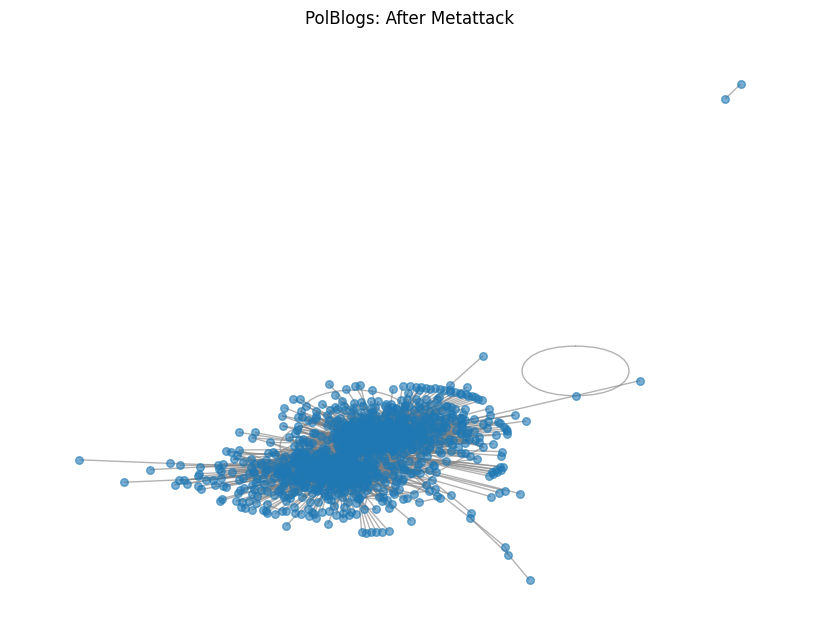

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([1490, 2])
test_mask shape: torch.Size([1490])
Ground truth labels shape: torch.Size([1490])
Accuracy after Metattack on PolBlogs: 0.8691
Fixing train_mask_shape for Texas...
Adjusting train_masks size for Texas...
Dataset: Texas

Number of nodes: 183
Number of features: 1703
Number of classes: 5

Epoch 0, Loss: 1.6578
Epoch 10, Loss: 1.1177
Epoch 20, Loss: 0.8418
Epoch 30, Loss: 0.5989
Epoch 40, Loss: 0.5237
Epoch 50, Loss: 0.4628
Epoch 60, Loss: 0.3902
Epoch 70, Loss: 0.4230
Epoch 80, Loss: 0.3631
Epoch 90, Loss: 0.3962
----------------------------------------------------------------------------------------------------
Original Graph


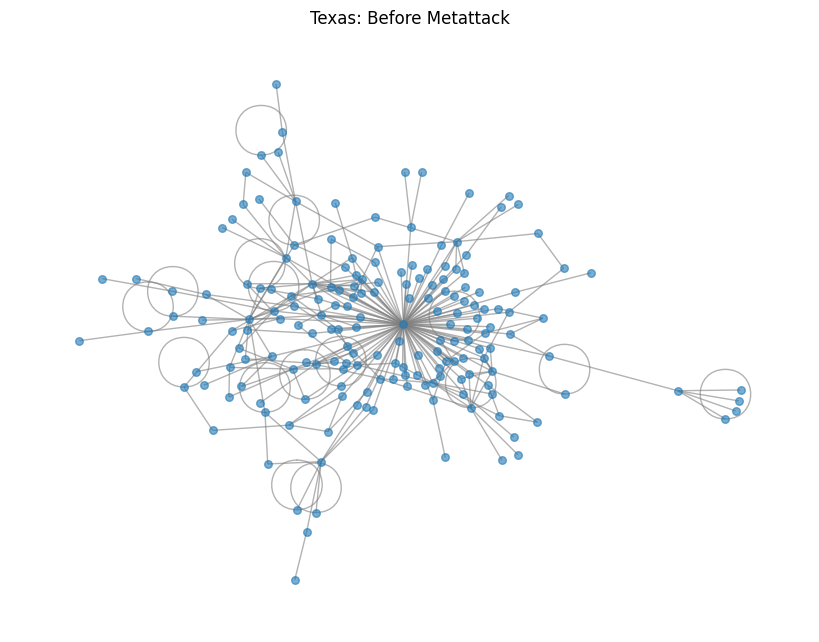

Perturbing graph:   0%|          | 0/5 [00:00<?, ?it/s]

GCN loss on unlabled data: 5.544821739196777
GCN acc on unlabled data: 0.35106382978723405
attack loss: 3.0241997241973877


Perturbing graph:  20%|██        | 1/5 [00:00<00:02,  1.49it/s]

GCN loss on unlabled data: 5.671285629272461
GCN acc on unlabled data: 0.2765957446808511
attack loss: 2.435565948486328


Perturbing graph:  60%|██████    | 3/5 [00:01<00:01,  1.74it/s]

GCN loss on unlabled data: 5.86802339553833
GCN acc on unlabled data: 0.32978723404255317
attack loss: 2.418851375579834


Perturbing graph:  80%|████████  | 4/5 [00:02<00:00,  1.98it/s]

GCN loss on unlabled data: 5.7341485023498535
GCN acc on unlabled data: 0.3404255319148936
attack loss: 2.449397563934326


Perturbing graph: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]

GCN loss on unlabled data: 5.655724048614502
GCN acc on unlabled data: 0.2872340425531915
attack loss: 2.4446897506713867


----------------------------------------------------------------------------------------------------
Perturbed Graph


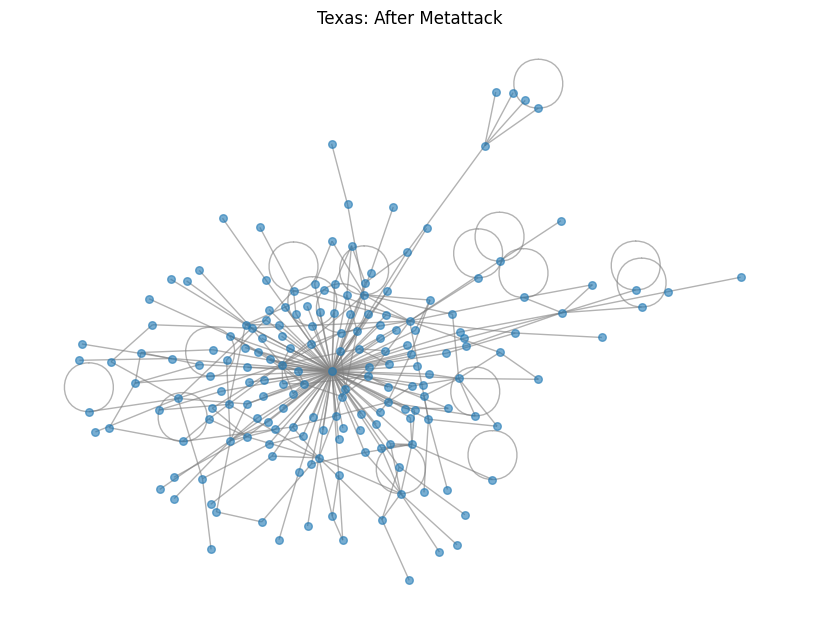

perturbed_adj type: <class 'torch.Tensor'>
Prediction shape: torch.Size([183, 5])
test_mask shape: torch.Size([183])
Ground truth labels shape: torch.Size([183])
Accuracy after Metattack on Texas: 0.3889


In [14]:
# all datasets, uncomment when debugged all
#datasets = ["Cora", "Citeseer", "PolBlogs", "Texas", "Flickr", "PubMed", "ogbn-proteins"]

# Base code these datasets run
datasets = ["Cora", "Citeseer", "PolBlogs", "Texas"]
# These datasets crash - reason: too big, use all available RAM
#datasets = [ "ogbn-proteins", "Flickr", "PubMed"]

for dataset_name in datasets:
  run_experiment(dataset_name)